In [1]:
%matplotlib inline
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.stats import multivariate_normal
from numpy.linalg import norm
import cv2

# Introduction to SIFT (Scale-Invariant Feature Transform)

---
## 参考资料

[Introduction to SIFT (Scale-Invariant Feature Transform)](https://docs.opencv.org/3.3.0/da/df5/tutorial_py_sift_intro.html)

[PythonSIFT](https://github.com/rmislam/PythonSIFT) 代码主要来源于这个仓库。

[SIFT: Theory and Practice](http://aishack.in/tutorials/sift-scale-invariant-feature-transform-features/) SIFT理论和实践。


In [2]:
# ndimage.imread?
# misc.imresize?
# cv2.line?
# cv2.circle?

In [3]:
img = misc.imread('../../data/lena.jpg', flatten=True)

In [4]:
height, width = img.shape

In [5]:
img.dtype

dtype('float32')

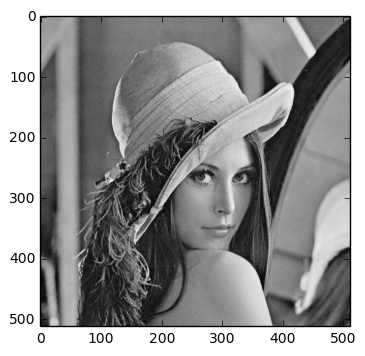

In [6]:
plt.imshow(img, cmap='gray')

In [7]:
# SIFT参数
s = 3 # 高斯图像数量为s+3
k = 2 ** (1.0 / s)
sigma = 1.6
pyr_num = s+3
threshold = 5

In [8]:
# 高斯滤波每一层标准差，其中1.3大约是np.sqrt(max(sigma*sigma-0.5*0.5*4, 0.01))可参考OpenCV中createInitialImage
kvec1 = np.array([1.3, sigma, sigma * k, sigma * (k ** 2), sigma * (k ** 3), sigma * (k ** 4)])
kvec2 = np.array([sigma * (k ** 2), sigma * (k ** 3), sigma * (k ** 4), sigma * (k ** 5), sigma * (k ** 6), sigma * (k ** 7)])
kvec3 = np.array([sigma * (k ** 5), sigma * (k ** 6), sigma * (k ** 7), sigma * (k ** 8), sigma * (k ** 9), sigma * (k ** 10)])
kvec4 = np.array([sigma * (k ** 8), sigma * (k ** 9), sigma * (k ** 10), sigma * (k ** 11), sigma * (k ** 12), sigma * (k ** 13)])
kvectotal = np.array([sigma, sigma * k, sigma * (k ** 2), sigma * (k ** 3), sigma * (k ** 4), sigma * (k ** 5), sigma * (k ** 6), sigma * (k ** 7), sigma * (k ** 8), sigma * (k ** 9), sigma * (k ** 10), sigma * (k ** 11)])

In [9]:
# 下采样图像，包括2，1，0.5，0.25
img_doubled = misc.imresize(img, 200, 'bilinear').astype(int)
# img_doubled.shape # (1024, 1024)
img_normal = misc.imresize(img_doubled, 50, 'bilinear').astype(int)
# img_normal.shape # (512, 512)
img_halved = misc.imresize(img_normal, 50, 'bilinear').astype(int)
# img_halved.shape # (256, 256)
img_quartered = misc.imresize(img_halved, 50, 'bilinear').astype(int)
# img_quartered.shape # (128, 128)

/Library/Python/2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):


In [10]:
# doubled_height, doubled_width = img_doubled.shape
# print(np.log(min(doubled_height, doubled_width))/np.log(2.)-2+1) # 实际的金字塔个数

In [11]:
# 初始化并构建高斯图像金字塔image pyramid
pyrlvl1 = np.zeros((img_doubled.shape[0], img_doubled.shape[1], pyr_num))
pyrlvl2 = np.zeros((img_normal.shape[0], img_normal.shape[1], pyr_num))
pyrlvl3 = np.zeros((img_halved.shape[0], img_halved.shape[1], pyr_num))
pyrlvl4 = np.zeros((img_quartered.shape[0], img_quartered.shape[1], pyr_num))

for n_octave_layer_index in range(pyr_num):
    pyrlvl1[:, :, n_octave_layer_index] = ndimage.filters.gaussian_filter(img_doubled, kvec1[n_octave_layer_index])
    pyrlvl2[:, :, n_octave_layer_index] = misc.imresize(ndimage.filters.gaussian_filter(img_doubled, kvec2[n_octave_layer_index]), 50, 'bilinear')
    pyrlvl3[:, :, n_octave_layer_index] = misc.imresize(ndimage.filters.gaussian_filter(img_doubled, kvec3[n_octave_layer_index]), 25, 'bilinear')
    pyrlvl4[:, :, n_octave_layer_index] = misc.imresize(ndimage.filters.gaussian_filter(img_doubled, kvec4[n_octave_layer_index]), 1.0/8.0, 'bilinear')

# 初始化并构建高斯差分金字塔image pyramid
diffpyrlvl1 = np.zeros((img_doubled.shape[0], img_doubled.shape[1], pyr_num-1))
diffpyrlvl2 = np.zeros((img_normal.shape[0], img_normal.shape[1], pyr_num-1))
diffpyrlvl3 = np.zeros((img_halved.shape[0], img_halved.shape[1], pyr_num-1))
diffpyrlvl4 = np.zeros((img_quartered.shape[0], img_quartered.shape[1], pyr_num-1))

for n_octave_layer_index in range(pyr_num-1):
    diffpyrlvl1[:, :, n_octave_layer_index] = pyrlvl1[:, :, n_octave_layer_index+1] - pyrlvl1[:, :, n_octave_layer_index]
    diffpyrlvl2[:, :, n_octave_layer_index] = pyrlvl2[:, :, n_octave_layer_index+1] - pyrlvl2[:, :, n_octave_layer_index]
    diffpyrlvl3[:, :, n_octave_layer_index] = pyrlvl3[:, :, n_octave_layer_index+1] - pyrlvl3[:, :, n_octave_layer_index]
    diffpyrlvl4[:, :, n_octave_layer_index] = pyrlvl4[:, :, n_octave_layer_index+1] - pyrlvl4[:, :, n_octave_layer_index]

/Library/Python/2.7/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [12]:
extrpyrlvl1 = np.zeros((img_doubled.shape[0], img_doubled.shape[1], pyr_num-3))
extrpyrlvl2 = np.zeros((img_normal.shape[0], img_normal.shape[1], pyr_num-3))
extrpyrlvl3 = np.zeros((img_halved.shape[0], img_halved.shape[1], pyr_num-3))
extrpyrlvl4 = np.zeros((img_quartered.shape[0], img_quartered.shape[1], pyr_num-3))

In [13]:
# 第一个octave寻找尺度空间极大值或极小值点
for i in range(1, pyr_num-2):
    for j in range(80, img_doubled.shape[0] - 80):
        for k in range(80, img_doubled.shape[1] - 80):
            if diffpyrlvl1[j, k, i] < threshold:
                continue
            
            # 寻找极大值或极小值
            maxbool = (diffpyrlvl1[j, k, i] > 0) # 当前值如果为正数那么极有可能是极大值
            minbool = (diffpyrlvl1[j, k, i] < 0) # 当前值如果为负数那么极有可能是极小值
            
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    for dk in range(-1, 2):
                        # 和其余26个元素相比较
                        if di==0 and dj==0 and dk==0:
                            continue
                        maxbool = maxbool and (diffpyrlvl1[j, k, i]>diffpyrlvl1[j+dj, k+dk, i+di])
                        minbool = minbool and (diffpyrlvl1[j, k, i]<diffpyrlvl1[j+dj, k+dk, i+di])
                        if maxbool==False and minbool==False:
                            break
                    if maxbool==False and minbool==False:
                        break
                if maxbool==False and minbool==False:
                    break
            if maxbool or minbool:
                dx = (diffpyrlvl1[j, k+1, i] - diffpyrlvl1[j, k-1, i]) * 0.5 / 255
                dy = (diffpyrlvl1[j+1, k, i] - diffpyrlvl1[j-1, k, i]) * 0.5 / 255
                ds = (diffpyrlvl1[j, k, i+1] - diffpyrlvl1[j, k, i-1]) * 0.5 / 255
                dxx = (diffpyrlvl1[j, k+1, i] + diffpyrlvl1[j, k-1, i] - 2 * diffpyrlvl1[j, k, i]) * 1.0 / 255
                dyy = (diffpyrlvl1[j+1, k, i] + diffpyrlvl1[j-1, k, i] - 2 * diffpyrlvl1[j, k, i]) * 1.0 / 255
                dss = (diffpyrlvl1[j, k, i+1] + diffpyrlvl1[j, k, i-1] - 2 * diffpyrlvl1[j, k, i]) * 1.0 / 255
                dxy = (diffpyrlvl1[j+1, k+1, i] - diffpyrlvl1[j+1, k-1, i] - diffpyrlvl1[j-1, k+1, i] + diffpyrlvl1[j-1, k-1, i]) * 0.25 / 255
                dxs = (diffpyrlvl1[j, k+1, i+1] - diffpyrlvl1[j, k-1, i+1] - diffpyrlvl1[j, k+1, i-1] + diffpyrlvl1[j, k-1, i-1]) * 0.25 / 255
                dys = (diffpyrlvl1[j+1, k, i+1] - diffpyrlvl1[j-1, k, i+1] - diffpyrlvl1[j+1, k, i-1] + diffpyrlvl1[j-1, k, i-1]) * 0.25 / 255
                
                dD = np.matrix([[dx], [dy], [ds]])
                H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                x_hat = np.linalg.lstsq(H, dD)[0]
                D_x_hat = diffpyrlvl1[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)
                
                r = 10.0
                if ((((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2))) and (np.absolute(x_hat[0]) < 0.5) and (np.absolute(x_hat[1]) < 0.5) and (np.absolute(x_hat[2]) < 0.5) and (np.absolute(D_x_hat) > 0.03):
                    extrpyrlvl1[j, k, i - 1] = 1
                

/Library/Python/2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [14]:
# np.argwhere(extrpyrlvl1==1)
# 极值点数目
ext1_num = np.sum(extrpyrlvl1)
print('ext1_num:', ext1_num)

('ext1_num:', 118.0)


In [15]:
# 第二个octave寻找尺度空间极大值或极小值点
for i in range(1, pyr_num-2):
    for j in range(40, img_normal.shape[0] - 40):
        for k in range(40, img_normal.shape[1] - 40):
            if diffpyrlvl2[j, k, i] < threshold:
                continue
            
            # 寻找极大值或极小值
            maxbool = (diffpyrlvl2[j, k, i] > 0) # 当前值如果为正数那么极有可能是极大值
            minbool = (diffpyrlvl2[j, k, i] < 0) # 当前值如果为负数那么极有可能是极小值
            
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    for dk in range(-1, 2):
                        # 和其余26个元素相比较
                        if di==0 and dj==0 and dk==0:
                            continue
                        maxbool = maxbool and (diffpyrlvl2[j, k, i]>diffpyrlvl2[j+dj, k+dk, i+di])
                        minbool = minbool and (diffpyrlvl2[j, k, i]<diffpyrlvl2[j+dj, k+dk, i+di])
                        if maxbool==False and minbool==False:
                            break
                    if maxbool==False and minbool==False:
                        break
                if maxbool==False and minbool==False:
                    break
            if maxbool or minbool:
                dx = (diffpyrlvl2[j, k+1, i] - diffpyrlvl2[j, k-1, i]) * 0.5 / 255
                dy = (diffpyrlvl2[j+1, k, i] - diffpyrlvl2[j-1, k, i]) * 0.5 / 255
                ds = (diffpyrlvl2[j, k, i+1] - diffpyrlvl2[j, k, i-1]) * 0.5 / 255
                dxx = (diffpyrlvl2[j, k+1, i] + diffpyrlvl2[j, k-1, i] - 2 * diffpyrlvl2[j, k, i]) * 1.0 / 255
                dyy = (diffpyrlvl2[j+1, k, i] + diffpyrlvl2[j-1, k, i] - 2 * diffpyrlvl2[j, k, i]) * 1.0 / 255
                dss = (diffpyrlvl2[j, k, i+1] + diffpyrlvl2[j, k, i-1] - 2 * diffpyrlvl2[j, k, i]) * 1.0 / 255
                dxy = (diffpyrlvl2[j+1, k+1, i] - diffpyrlvl2[j+1, k-1, i] - diffpyrlvl2[j-1, k+1, i] + diffpyrlvl2[j-1, k-1, i]) * 0.25 / 255
                dxs = (diffpyrlvl2[j, k+1, i+1] - diffpyrlvl2[j, k-1, i+1] - diffpyrlvl2[j, k+1, i-1] + diffpyrlvl2[j, k-1, i-1]) * 0.25 / 255
                dys = (diffpyrlvl2[j+1, k, i+1] - diffpyrlvl2[j-1, k, i+1] - diffpyrlvl2[j+1, k, i-1] + diffpyrlvl2[j-1, k, i-1]) * 0.25 / 255
                
                dD = np.matrix([[dx], [dy], [ds]])
                H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                x_hat = np.linalg.lstsq(H, dD)[0]
                D_x_hat = diffpyrlvl2[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)
                
                r = 10.0
                if ((((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2))) and (np.absolute(x_hat[0]) < 0.5) and (np.absolute(x_hat[1]) < 0.5) and (np.absolute(x_hat[2]) < 0.5) and (np.absolute(D_x_hat) > 0.03):
                    extrpyrlvl2[j, k, i - 1] = 1

/Library/Python/2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [16]:
# np.argwhere(extrpyrlvl2==1)
# 极值点数目
ext2_num = np.sum(extrpyrlvl2)
print('ext2_num:', ext2_num)

('ext2_num:', 257.0)


In [17]:
# 第三个octave寻找尺度空间极大值或极小值点
for i in range(1, pyr_num-2):
    for j in range(20, img_halved.shape[0] - 20):
        for k in range(20, img_halved.shape[1] - 20):
            if diffpyrlvl3[j, k, i] < threshold:
                continue
            
            # 寻找极大值或极小值
            maxbool = (diffpyrlvl3[j, k, i] > 0) # 当前值如果为正数那么极有可能是极大值
            minbool = (diffpyrlvl3[j, k, i] < 0) # 当前值如果为负数那么极有可能是极小值
            
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    for dk in range(-1, 2):
                        # 和其余26个元素相比较
                        if di==0 and dj==0 and dk==0:
                            continue
                        maxbool = maxbool and (diffpyrlvl3[j, k, i]>diffpyrlvl3[j+dj, k+dk, i+di])
                        minbool = minbool and (diffpyrlvl3[j, k, i]<diffpyrlvl3[j+dj, k+dk, i+di])
                        if maxbool==False and minbool==False:
                            break
                    if maxbool==False and minbool==False:
                        break
                if maxbool==False and minbool==False:
                    break
            if maxbool or minbool:
                dx = (diffpyrlvl3[j, k+1, i] - diffpyrlvl3[j, k-1, i]) * 0.5 / 255
                dy = (diffpyrlvl3[j+1, k, i] - diffpyrlvl3[j-1, k, i]) * 0.5 / 255
                ds = (diffpyrlvl3[j, k, i+1] - diffpyrlvl3[j, k, i-1]) * 0.5 / 255
                dxx = (diffpyrlvl3[j, k+1, i] + diffpyrlvl3[j, k-1, i] - 2 * diffpyrlvl3[j, k, i]) * 1.0 / 255
                dyy = (diffpyrlvl3[j+1, k, i] + diffpyrlvl3[j-1, k, i] - 2 * diffpyrlvl3[j, k, i]) * 1.0 / 255
                dss = (diffpyrlvl3[j, k, i+1] + diffpyrlvl3[j, k, i-1] - 2 * diffpyrlvl3[j, k, i]) * 1.0 / 255
                dxy = (diffpyrlvl3[j+1, k+1, i] - diffpyrlvl3[j+1, k-1, i] - diffpyrlvl3[j-1, k+1, i] + diffpyrlvl3[j-1, k-1, i]) * 0.25 / 255
                dxs = (diffpyrlvl3[j, k+1, i+1] - diffpyrlvl3[j, k-1, i+1] - diffpyrlvl3[j, k+1, i-1] + diffpyrlvl3[j, k-1, i-1]) * 0.25 / 255
                dys = (diffpyrlvl3[j+1, k, i+1] - diffpyrlvl3[j-1, k, i+1] - diffpyrlvl3[j+1, k, i-1] + diffpyrlvl3[j-1, k, i-1]) * 0.25 / 255
                
                dD = np.matrix([[dx], [dy], [ds]])
                H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                x_hat = np.linalg.lstsq(H, dD)[0]
                D_x_hat = diffpyrlvl3[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)
                
                r = 10.0
                if ((((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2))) and (np.absolute(x_hat[0]) < 0.5) and (np.absolute(x_hat[1]) < 0.5) and (np.absolute(x_hat[2]) < 0.5) and (np.absolute(D_x_hat) > 0.03):
                    extrpyrlvl3[j, k, i - 1] = 1

/Library/Python/2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [18]:
# np.argwhere(extrpyrlvl3==1)
# 极值点数目
ext3_num = np.sum(extrpyrlvl3)
print('ext3_num:', ext3_num)

('ext3_num:', 160.0)


In [19]:
# 第四个octave寻找尺度空间极大值或极小值点
for i in range(1, pyr_num-2):
    for j in range(10, img_quartered.shape[0] - 10):
        for k in range(10, img_quartered.shape[1] - 10):
            if diffpyrlvl4[j, k, i] < threshold:
                continue
            
            # 寻找极大值或极小值
            maxbool = (diffpyrlvl4[j, k, i] > 0) # 当前值如果为正数那么极有可能是极大值
            minbool = (diffpyrlvl4[j, k, i] < 0) # 当前值如果为负数那么极有可能是极小值
            
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    for dk in range(-1, 2):
                        # 和其余26个元素相比较
                        if di==0 and dj==0 and dk==0:
                            continue
                        maxbool = maxbool and (diffpyrlvl4[j, k, i]>diffpyrlvl4[j+dj, k+dk, i+di])
                        minbool = minbool and (diffpyrlvl4[j, k, i]<diffpyrlvl4[j+dj, k+dk, i+di])
                        if maxbool==False and minbool==False:
                            break
                    if maxbool==False and minbool==False:
                        break
                if maxbool==False and minbool==False:
                    break
            if maxbool or minbool:
                dx = (diffpyrlvl4[j, k+1, i] - diffpyrlvl4[j, k-1, i]) * 0.5 / 255
                dy = (diffpyrlvl4[j+1, k, i] - diffpyrlvl4[j-1, k, i]) * 0.5 / 255
                ds = (diffpyrlvl4[j, k, i+1] - diffpyrlvl4[j, k, i-1]) * 0.5 / 255
                dxx = (diffpyrlvl4[j, k+1, i] + diffpyrlvl4[j, k-1, i] - 2 * diffpyrlvl4[j, k, i]) * 1.0 / 255
                dyy = (diffpyrlvl4[j+1, k, i] + diffpyrlvl4[j-1, k, i] - 2 * diffpyrlvl4[j, k, i]) * 1.0 / 255
                dss = (diffpyrlvl4[j, k, i+1] + diffpyrlvl4[j, k, i-1] - 2 * diffpyrlvl4[j, k, i]) * 1.0 / 255
                dxy = (diffpyrlvl4[j+1, k+1, i] - diffpyrlvl4[j+1, k-1, i] - diffpyrlvl4[j-1, k+1, i] + diffpyrlvl4[j-1, k-1, i]) * 0.25 / 255
                dxs = (diffpyrlvl4[j, k+1, i+1] - diffpyrlvl4[j, k-1, i+1] - diffpyrlvl4[j, k+1, i-1] + diffpyrlvl4[j, k-1, i-1]) * 0.25 / 255
                dys = (diffpyrlvl4[j+1, k, i+1] - diffpyrlvl4[j-1, k, i+1] - diffpyrlvl4[j+1, k, i-1] + diffpyrlvl4[j-1, k, i-1]) * 0.25 / 255
                
                dD = np.matrix([[dx], [dy], [ds]])
                H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                x_hat = np.linalg.lstsq(H, dD)[0]
                D_x_hat = diffpyrlvl4[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)
                
                r = 10.0
                if ((((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2))) and (np.absolute(x_hat[0]) < 0.5) and (np.absolute(x_hat[1]) < 0.5) and (np.absolute(x_hat[2]) < 0.5) and (np.absolute(D_x_hat) > 0.03):
                    extrpyrlvl4[j, k, i - 1] = 1

/Library/Python/2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [20]:
# np.argwhere(extrpyrlvl4==1)
# 极值点数目
ext4_num = np.sum(extrpyrlvl4)
print('ext4_num:', ext4_num)

('ext4_num:', 27.0)


In [21]:
# 梯度幅值和方向Gradient magnitude and orientation
magpyrlvl1 = np.zeros_like(extrpyrlvl1)
magpyrlvl2 = np.zeros_like(extrpyrlvl2)
magpyrlvl3 = np.zeros_like(extrpyrlvl3)
magpyrlvl4 = np.zeros_like(extrpyrlvl4)

oripyrlvl1 = np.zeros_like(extrpyrlvl1)
oripyrlvl2 = np.zeros_like(extrpyrlvl2)
oripyrlvl3 = np.zeros_like(extrpyrlvl3)
oripyrlvl4 = np.zeros_like(extrpyrlvl4)

In [22]:
# 计算第一层关键点方向
for i in range(0, pyr_num-3):
    for j in range(1, img_doubled.shape[0] - 1):
        for k in range(1, img_doubled.shape[1] - 1):
            magpyrlvl1[j, k, i] = ( ((img_doubled[j+1, k] - img_doubled[j-1, k]) ** 2) + ((img_doubled[j, k+1] - img_doubled[j, k-1]) ** 2) ) ** 0.5   
            oripyrlvl1[j, k, i] = (36 / (2 * np.pi)) * (np.pi + np.arctan2((img_doubled[j, k+1] - img_doubled[j, k-1]), (img_doubled[j+1, k] - img_doubled[j-1, k])))  
            
            

In [23]:
# 计算第二层关键点方向
for i in range(0, pyr_num-3):
    for j in range(1, img_normal.shape[0] - 1):
        for k in range(1, img_normal.shape[1] - 1):
            magpyrlvl2[j, k, i] = ( ((img_normal[j+1, k] - img_normal[j-1, k]) ** 2) + ((img_normal[j, k+1] - img_normal[j, k-1]) ** 2) ) ** 0.5   
            oripyrlvl2[j, k, i] = (36 / (2 * np.pi)) * (np.pi + np.arctan2((img_normal[j, k+1] - img_normal[j, k-1]), (img_normal[j+1, k] - img_normal[j-1, k])))  
            
     

In [24]:
# 计算第三层关键点方向
for i in range(0, pyr_num-3):
    for j in range(1, img_halved.shape[0] - 1):
        for k in range(1, img_halved.shape[1] - 1):
            magpyrlvl3[j, k, i] = ( ((img_halved[j+1, k] - img_halved[j-1, k]) ** 2) + ((img_halved[j, k+1] - img_halved[j, k-1]) ** 2) ) ** 0.5   
            oripyrlvl3[j, k, i] = (36 / (2 * np.pi)) * (np.pi + np.arctan2((img_halved[j, k+1] - img_halved[j, k-1]), (img_halved[j+1, k] - img_halved[j-1, k])))  
            
     

In [25]:
# 计算第四层关键点方向
for i in range(0, pyr_num-3):
    for j in range(1, img_quartered.shape[0] - 1):
        for k in range(1, img_quartered.shape[1] - 1):
            magpyrlvl4[j, k, i] = ( ((img_quartered[j+1, k] - img_quartered[j-1, k]) ** 2) + ((img_quartered[j, k+1] - img_quartered[j, k-1]) ** 2) ) ** 0.5   
            oripyrlvl4[j, k, i] = (36 / (2 * np.pi)) * (np.pi + np.arctan2((img_quartered[j, k+1] - img_quartered[j, k-1]), (img_quartered[j+1, k] - img_quartered[j-1, k])))  
            
     

In [26]:
# 提取关键点 极值点个数*4方向
extr_sum = int(np.sum(extrpyrlvl1) + np.sum(extrpyrlvl2) + np.sum(extrpyrlvl3) + np.sum(extrpyrlvl4))
keypoints = np.zeros((extr_sum, 4))
# print('keypoints.shape:', keypoints.shape)

count = 0 # 关键点索引
for i in range(0, pyr_num-3):
    for j in range(80, img_doubled.shape[0] - 80):
        for k in range(80, img_doubled.shape[1] - 80):
            if extrpyrlvl1[j, k, i] == 1:
                # std设置为std=1.5 * kvectotal[i]
                gaussian_window = multivariate_normal(mean=[j, k], cov=((1.5 * kvectotal[i]) ** 2))
                two_sd = np.floor(2 * 1.5 * kvectotal[i])
                # 方向向量
                orient_hist = np.zeros([36,1])
                for x in range(int(-1 * two_sd * 2), int(two_sd * 2) + 1):
                    ylim = int((((two_sd * 2) ** 2) - (np.absolute(x) ** 2)) ** 0.5)
                    for y in range(-1 * ylim, ylim + 1):
                        if j + x < 0 or j + x > img_doubled.shape[0] - 1 or k + y < 0 or k + y > img_doubled.shape[1] - 1:
                            continue
                        weight = magpyrlvl1[j + x, k + y, i] * gaussian_window.pdf([j + x, k + y])
                        # 设置bin_idx为0-35
                        bin_idx = np.clip(np.floor(oripyrlvl1[j + x, k + y, i]), 0, 35).astype(int)
                        orient_hist[bin_idx] += weight
                maxval = np.amax(orient_hist)
                maxidx = np.argmax(orient_hist)
                keypoints[count, :] = np.array([int(j * 0.5), int(k * 0.5), kvectotal[i], maxidx])
                count += 1
                
                # 去除最大值后的最大值和最大值的比较
                orient_hist[maxidx] = 0
                newmaxval = np.amax(orient_hist)
#                 print('count:', count)
#                 print('keypoints:', keypoints[count])
                # 第二个较大点也比较大，直至较小的最大值
                while newmaxval > 0.8 * maxval:
                    newmaxidx = np.argmax(orient_hist)
                    np.append(keypoints, np.array([[int(j * 0.5), int(k * 0.5), kvectotal[i], newmaxidx]]), axis=0)
                    # 去除较大的最大值后重新比较
                    orient_hist[newmaxidx] = 0
                    newmaxval = np.amax(orient_hist)
#                 print('keypoints:', keypoints[count])
for i in range(0, pyr_num-3):
    for j in range(40, img_normal.shape[0] - 40):
        for k in range(40, img_normal.shape[1] - 40):
            if extrpyrlvl2[j, k, i] == 1:
                # std设置为std=1.5 * kvectotal[i]
                gaussian_window = multivariate_normal(mean=[j, k], cov=((1.5 * kvectotal[i]) ** 2))
                two_sd = np.floor(2 * 1.5 * kvectotal[i])
                # 方向向量
                orient_hist = np.zeros([36,1])
                for x in range(int(-1 * two_sd * 2), int(two_sd * 2) + 1):
                    ylim = int((((two_sd * 2) ** 2) - (np.absolute(x) ** 2)) ** 0.5)
                    for y in range(-1 * ylim, ylim + 1):
                        if j + x < 0 or j + x > img_normal.shape[0] - 1 or k + y < 0 or k + y > img_normal.shape[1] - 1:
                            continue
                        weight = magpyrlvl2[j + x, k + y, i] * gaussian_window.pdf([j + x, k + y])
                        # 设置bin_idx为0-35
                        bin_idx = np.clip(np.floor(oripyrlvl2[j + x, k + y, i]), 0, 35).astype(int)
                        orient_hist[bin_idx] += weight
                maxval = np.amax(orient_hist)
                maxidx = np.argmax(orient_hist)
                keypoints[count, :] = np.array([int(j * 0.5), int(k * 0.5), kvectotal[i], maxidx])
                count += 1
                
                # 去除最大值后的最大值和最大值的比较
                orient_hist[maxidx] = 0
                newmaxval = np.amax(orient_hist)
#                 print('count:', count)
#                 print('keypoints:', keypoints[count])
                # 第二个较大点也比较大，直至较小的最大值
                while newmaxval > 0.8 * maxval:
                    newmaxidx = np.argmax(orient_hist)
                    np.append(keypoints, np.array([[int(j * 0.5), int(k * 0.5), kvectotal[i], newmaxidx]]), axis=0)
                    # 去除较大的最大值后重新比较
                    orient_hist[newmaxidx] = 0
                    newmaxval = np.amax(orient_hist)
#                 print('keypoints:', keypoints[count])
for i in range(0, pyr_num-3):
    for j in range(20, img_halved.shape[0] - 20):
        for k in range(20, img_halved.shape[1] - 20):
            if extrpyrlvl3[j, k, i] == 1:
                # std设置为std=1.5 * kvectotal[i]
                gaussian_window = multivariate_normal(mean=[j, k], cov=((1.5 * kvectotal[i]) ** 2))
                two_sd = np.floor(2 * 1.5 * kvectotal[i])
                # 方向向量
                orient_hist = np.zeros([36,1])
                for x in range(int(-1 * two_sd * 2), int(two_sd * 2) + 1):
                    ylim = int((((two_sd * 2) ** 2) - (np.absolute(x) ** 2)) ** 0.5)
                    for y in range(-1 * ylim, ylim + 1):
                        if j + x < 0 or j + x > img_halved.shape[0] - 1 or k + y < 0 or k + y > img_halved.shape[1] - 1:
                            continue
                        weight = magpyrlvl3[j + x, k + y, i] * gaussian_window.pdf([j + x, k + y])
                        # 设置bin_idx为0-35
                        bin_idx = np.clip(np.floor(oripyrlvl3[j + x, k + y, i]), 0, 35).astype(int)
                        orient_hist[bin_idx] += weight
                maxval = np.amax(orient_hist)
                maxidx = np.argmax(orient_hist)
                keypoints[count, :] = np.array([int(j * 0.5), int(k * 0.5), kvectotal[i], maxidx])
                count += 1
                
                # 去除最大值后的最大值和最大值的比较
                orient_hist[maxidx] = 0
                newmaxval = np.amax(orient_hist)
#                 print('count:', count)
#                 print('keypoints:', keypoints[count])
                # 第二个较大点也比较大，直至较小的最大值
                while newmaxval > 0.8 * maxval:
                    newmaxidx = np.argmax(orient_hist)
                    np.append(keypoints, np.array([[int(j * 0.5), int(k * 0.5), kvectotal[i], newmaxidx]]), axis=0)
                    # 去除较大的最大值后重新比较
                    orient_hist[newmaxidx] = 0
                    newmaxval = np.amax(orient_hist)
#                 print('keypoints:', keypoints[count])
for i in range(0, pyr_num-3):
    for j in range(10, img_quartered.shape[0] - 10):
        for k in range(10, img_quartered.shape[1] - 10):
            if extrpyrlvl4[j, k, i] == 1:
                # std设置为std=1.5 * kvectotal[i]
                gaussian_window = multivariate_normal(mean=[j, k], cov=((1.5 * kvectotal[i]) ** 2))
                two_sd = np.floor(2 * 1.5 * kvectotal[i])
                # 方向向量
                orient_hist = np.zeros([36,1])
                for x in range(int(-1 * two_sd * 2), int(two_sd * 2) + 1):
                    ylim = int((((two_sd * 2) ** 2) - (np.absolute(x) ** 2)) ** 0.5)
                    for y in range(-1 * ylim, ylim + 1):
                        if j + x < 0 or j + x > img_quartered.shape[0] - 1 or k + y < 0 or k + y > img_quartered.shape[1] - 1:
                            continue
                        weight = extrpyrlvl4[j + x, k + y, i] * gaussian_window.pdf([j + x, k + y])
                        # 设置bin_idx为0-35
                        bin_idx = np.clip(np.floor(oripyrlvl4[j + x, k + y, i]), 0, 35).astype(int)
                        orient_hist[bin_idx] += weight
                maxval = np.amax(orient_hist)
                maxidx = np.argmax(orient_hist)
                keypoints[count, :] = np.array([int(j * 0.5), int(k * 0.5), kvectotal[i], maxidx])
                count += 1
                
                # 去除最大值后的最大值和最大值的比较
                orient_hist[maxidx] = 0
                newmaxval = np.amax(orient_hist)
#                 print('count:', count)
#                 print('keypoints:', keypoints[count])
                # 第二个较大点也比较大，直至较小的最大值
                while newmaxval > 0.8 * maxval:
                    newmaxidx = np.argmax(orient_hist)
                    np.append(keypoints, np.array([[int(j * 0.5), int(k * 0.5), kvectotal[i], newmaxidx]]), axis=0)
                    # 去除较大的最大值后重新比较
                    orient_hist[newmaxidx] = 0
                    newmaxval = np.amax(orient_hist)
#                 print('keypoints:', keypoints[count])
# print('keypoints:', keypoints)
# print('keypoints.shape:', keypoints.shape)                      

In [27]:
# print('keypoints:', keypoints)

In [28]:
# 计算描述子
magpyr = np.zeros((img_normal.shape[0], img_normal.shape[1], (pyr_num-3)*4))
oripyr = np.zeros((img_normal.shape[0], img_normal.shape[1], (pyr_num-3)*4))

for i in range(0, pyr_num-3):
    magmax = np.amax(magpyrlvl1[:, :, i])
    magpyr[:, :, i] = misc.imresize(magpyrlvl1[:, :, i], (img_normal.shape[0], img_normal.shape[1]), "bilinear").astype(float)
    magpyr[:, :, i] = (magmax / np.amax(magpyr[:, :, i])) * magpyr[:, :, i]  
    oripyr[:, :, i] = misc.imresize(oripyrlvl1[:, :, i], (img_normal.shape[0], img_normal.shape[1]), "bilinear").astype(int)    
    oripyr[:, :, i] = ((36.0 / np.amax(oripyr[:, :, i])) * oripyr[:, :, i]).astype(int)

for i in range(0, pyr_num-3):
    magpyr[:, :, i+3] = (magpyrlvl2[:, :, i]).astype(float)
    oripyr[:, :, i+3] = (oripyrlvl2[:, :, i]).astype(int)             

for i in range(0, pyr_num-3):
    magpyr[:, :, i+6] = misc.imresize(magpyrlvl3[:, :, i], (img_normal.shape[0], img_normal.shape[1]), "bilinear").astype(int)   
    oripyr[:, :, i+6] = misc.imresize(oripyrlvl3[:, :, i], (img_normal.shape[0], img_normal.shape[1]), "bilinear").astype(int)    

for i in range(0, pyr_num-3):
    magpyr[:, :, i+9] = misc.imresize(magpyrlvl4[:, :, i], (img_normal.shape[0], img_normal.shape[1]), "bilinear").astype(int)   
    oripyr[:, :, i+9] = misc.imresize(oripyrlvl4[:, :, i], (img_normal.shape[0], img_normal.shape[1]), "bilinear").astype(int)

In [29]:
descriptors = np.zeros([keypoints.shape[0], 128])

for i in range(0, keypoints.shape[0]): 
    for x in range(-8, 8):
        for y in range(-8, 8):
            theta = 10 * keypoints[i,3] * np.pi / 180.0
            xrot = int(np.round((np.cos(theta) * x) - (np.sin(theta) * y)))
            yrot = int(np.round((np.sin(theta) * x) + (np.cos(theta) * y)))
            scale_idx = np.argwhere(kvectotal == keypoints[i,2])[0][0]
            x0 = int(keypoints[i,0])
            y0 = int(keypoints[i,1])
            gaussian_window = multivariate_normal(mean=[x0,y0], cov=8) 
            weight = magpyr[x0 + xrot, y0 + yrot, scale_idx] * gaussian_window.pdf([x0 + xrot, y0 + yrot])
            angle = oripyr[x0 + xrot, y0 + yrot, scale_idx] - keypoints[i,3]
            if angle < 0:
                angle = 36 + angle

            bin_idx = np.clip(np.floor((8.0 / 36) * angle), 0, 7).astype(int)
            descriptors[i, 32 * int((x + 8)/4) + 8 * int((y + 8)/4) + bin_idx] += weight

    descriptors[i, :] = descriptors[i, :] / norm(descriptors[i, :]) 
    descriptors[i, :] = np.clip(descriptors[i, :], 0, 0.2)
    descriptors[i, :] = descriptors[i, :] / norm(descriptors[i, :])

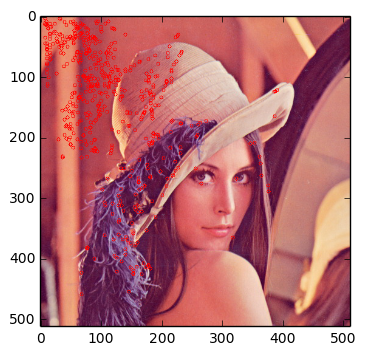

In [30]:
img_rgb = misc.imread('../../data/lena.jpg')
for keypoint in keypoints:
    row = int(keypoint[0])
    col = int(keypoint[1])
#     print('keypoint.shape:', keypoint.shape)
#     print('keypoint:', keypoint)
#     print('x:', x)
#     print('y:', y)
    cv2.circle(img_rgb, center=(col, row), radius=3, color=(255, 0, 0))
plt.imshow(img_rgb)